In [3]:
import torch
from torch import nn as nn
from torch.distributions import Normal, multivariate_normal
from torch.utils.data import Dataset, DataLoader
import numpy as np
import collections
from typing import Iterable
import scipy.sparse as sp_sparse
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from tqdm import trange
import sys
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scanpy as sc

/ysm-gpfs/pi/zhao/Softwares/Anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = torch.device("cpu")

In [3]:
class Generate_X:
    def __init__(self, p, give_mean = 'zero', give_sigma = 'one'):
        """
        give_sigma: whether the Sigma is diagonal matrix and same across cell types.
                    'one': The variances of genes are all ones.
                    'linspace': The variances of genes are different but even spaced numbers
                    'uniform': The variances of gene are randomly generated from [0,1]
        """
        self.p = p
        if give_mean is 'zero':
            self.mean = np.array([0]*self.p, dtype =float)
        elif give_mean is 'linspace':
            self.mean = np.linspace(0,2,num = self.p, dtype=float)
        elif give_mean is 'uniform':
            self.mean =  np.random.rand(self.p, dtype = float)
        else:
            print('Wrong argument!')
            pass
        if give_sigma is 'one':
            self.sigma = np.array([1]*self.p)
        elif give_sigma is 'linspace':
            self.sigma = np.linspace(0,2,num = self.p)
        elif give_mean is 'uniform':
            self.sigma =  np.random.rand(self.p)
        else:
            print('Wrong argument!')
            pass
        

    def sym_Sigma(self):
        p = self.p
        L = np.tril(np.random.random((p,p))*2,0)
        sparse = np.random.binomial(1,0.2,(p,p))
        diag_indices = np.diag_indices(p)
        sparse[diag_indices] = 1
        L = L * sparse
        S = np.matmul(L,L.transpose())
        return S

    def generate(self, n_ct, n_vec, same_mean = True, same_sigma = True):
        """
        n_ct: int, the number of cell types
        n_vec: the vector of cell size
        """
        assert n_ct == len(n_vec)
        ct_label = []
        rst = []
        covmat = []
        meanmat = []
        for ct in range(n_ct):  # ct: cell type
            if same_sigma:
                Sigma = np.diag(self.sigma)
            else:
                Sigma = self.sym_Sigma()
            Sigma = Sigma.astype(float)
            if same_mean:
                mean = self.mean
            else:
                mean = (np.random.rand(self.p)-0.5)*10
            MVN = np.random.multivariate_normal(mean, Sigma, n_vec[ct])
            #print(MVN)
            rst.append(MVN)
            ct_label.append(np.array([ct]*n_vec[ct]))
            covmat.append(Sigma)
            meanmat.append(mean)
        mat = np.array(rst)
        ct_label = np.array(ct_label)
        self.X = np.reshape(mat, (-1,self.p))
        self.ct_label = np.reshape(ct_label, (-1,))
        self.covmat = covmat
        self.meanmat = meanmat
        # print(self.X, self.ct_label)

In [4]:
def sim_sample_indices(sample_size):
    sample_indices = [[i]*sample_size[i] for i in range(len(sample_size))]
    return np.asarray(sample_indices).flatten()

In [5]:
class CytofDataset_Sim(Dataset):
    """ Create CyTOF dataset for Pytorch in Simulation
        The class contains __len__() and __getitem__() which could be used for dataloader.
    
    """

    def __init__(self,X, sample_indices, label_indices):
        self.dense = type(X) is np.ndarray
        self._X = np.ascontiguousarray(X, dtype=np.float32) if self.dense else X
        self.nb_genes = self.X.shape[1]
        self.samples, self.n_samples, self.sample_dict = arrange_categories(sample_indices)
        self.labels, self.n_labels, self.label_dict = arrange_categories(label_indices)

    @property
    def X(self):
        return self._X

    def __len__(self):
        return self._X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.samples[idx], self.labels[idx]
    
#    def collate_fn(self, batch):
#        indexes = np.array(batch)
#        X = self.X[indexes]
#        return self.collate_fn_end(X, indexes)
#    
#    def collate_fn_end(self, X, indexes):

#        if self.dense:
#            X = torch.from_numpy(X)
#        else:
#            X = torch.FloatTensor(X.toarray())
#        return X,  torch.LongTensor(self.samples[indexes]), \
#                   torch.LongTensor(self.labels[indexes])


    def get_sample(self, sample_sublist):
        """
        sample_sublist: list
        """
        loc = np.array([np.where(self.samples == self.sample_dict[sample]) for sample in sample_sublist]).flatten()
        X_sub = self._X[loc]
        samples_sub = self.samples[loc]
        labels_sub = self.labels[loc]
        return X_sub, samples_sub, labels_sub
    
    def get_celltype(self, celltype_sublist):
        """
        celltype_sublist: list
        """
        loc = np.array([np.where(self.labels == self.label_dict[batch]) for label in celltype_sublist]).flatten()
        X_sub = self._X[loc]
        samples_sub = self.samples[loc]
        labels_sub = self.labels[loc]
        return X_sub, samples_sub, labels_sub

In [6]:
def arrange_categories(original_categories, mapping_from=None, mapping_to=None):
    unique_categories = np.unique(original_categories)
    n_categories = len(unique_categories)
    batch_dict = dict()
    if mapping_to is None:
        mapping_to = range(n_categories)
    if mapping_from is None:
        mapping_from = unique_categories
    assert n_categories <= len(mapping_from)  # one cell_type can have no instance in dataset # Haven't debug it. Assume we have more than one cell type.
    assert len(mapping_to) == len(mapping_from)

    new_categories = np.copy(original_categories)
    for idx_from, idx_to in zip(mapping_from, mapping_to):
        # print(idx_from, idx_to)
        new_categories[original_categories == idx_from] = idx_to
        batch_dict[idx_from] = idx_to
    return new_categories.astype(int), n_categories, batch_dict

In [7]:
class FCLayers(nn.Module):
    r"""A helper class to build fully-connected layers for a neural network.

    :param n_in: The dimensionality of the input
    :param n_out: The dimensionality of the output
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :param dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_in: int, n_out: int, 
                 n_layers: int = 1, n_hidden: int = 128, dropout_rate: float = 0.1, use_batch_norm=True):
        super(FCLayers, self).__init__()
        layers_dim = [n_in] + (n_layers - 1) * [n_hidden] + [n_out]

        self.fc_layers = nn.Sequential(collections.OrderedDict(
            [('Layer {}'.format(i), nn.Sequential(
                nn.Linear(n_in , n_out),
                nn.BatchNorm1d(n_out, momentum=.01, eps=0.001) if use_batch_norm else None,
                nn.ReLU(),
                nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None))
             for i, (n_in, n_out) in enumerate(zip(layers_dim[:-1], layers_dim[1:]))] ))

    def forward(self, x: torch.Tensor):
        r"""Forward computation on ``x``.

        :param x: tensor of values with shape ``(n_in,)``
        :return: tensor of shape ``(n_out,)``
        :rtype: :py:class:`torch.Tensor`
        """
        
        for layers in self.fc_layers:
            for layer in layers:
                if layer is not None:
                    if isinstance(layer, nn.BatchNorm1d):
                        if x.dim() == 3:
                            x = torch.cat([(layer(slice_x)).unsqueeze(0) for slice_x in x], dim=0)
                        else:
                            x = layer(x)
                    else:
                        x = layer(x)
        return x

In [7]:
class Manual_Layers(nn.Module):
    def __init__(self, n_in=10, n_hidden=100, n_out=2):
        super(FCLayers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_in, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2),
        )
        
        
    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        
        return x

In [8]:
class Encoder(nn.Module):
    r"""Encodes data of ``n_input`` dimensions into a latent space of ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (data space)
    :param n_output: The dimensionality of the output (latent space)
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int,
                 n_layers: int = 1,
                 n_hidden: int = 128, dropout_rate: float = 0.1):
        super(Encoder, self).__init__()

        #self.encoder = FCLayers(n_in=n_input, n_out=n_hidden, n_layers=n_layers,
        #                        n_hidden=n_hidden, dropout_rate=dropout_rate)
        #self.mean_encoder = nn.Linear(n_hidden, n_output)
        #self.var_encoder = nn.Linear(n_hidden, n_output)
            
        self.encoder = Manual_Layers(n_in = n_input, n_hidden = n_hidden, n_out = n_output)
       

    def reparameterize(self, mu, var):
        return Normal(mu, var.sqrt()).rsample()
    
    def encoder_function(self, x):
        h = self.encoder(x)
        q_m, q_v = torch.chunk(h, 2, dim=1)
        return q_m, q_v

    def forward(self, x: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Encodes the data into latent space using the encoder network
         #. Generates a mean \\( q_m \\) and variance \\( q_v \\) (clamped to \\( [-5, 5] \\))
         #. Samples a new value from an i.i.d. multivariate normal \\( \\sim N(q_m, \\mathbf{I}q_v) \\)

        :param x: tensor with shape (n_input,)
        :return: tensors of shape ``(n_latent,)`` for mean and var, and sample
        :rtype: 3-tuple of :py:class:`torch.Tensor`
        """

        # Parameters for latent distribution
        q_m, q_v = self.encoder_function(x)
        q_v = torch.exp(q_v)
        
        #q = self.encoder(x)
        #q_m = self.mean_encoder(q)
        #q_v = torch.exp(self.var_encoder(q))  # (computational stability safeguard)torch.clamp(, -5, 5)
        latent = self.reparameterize(q_m, q_v)
        return q_m, q_v, latent

In [9]:
class DecoderVCSC(nn.Module):
    r"""Decodes data from latent space of ``n_input`` dimensions ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (latent space)
    :param n_output: The dimensionality of the output (data space). It is also the number of genes
    :param n_cat_list: A list containing the number of categories
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    """

    def __init__(self, n_input: int, n_output: int,
                 n_layers: int = 1,
                 n_hidden: int = 128):
        super(DecoderVCSC, self).__init__()

        # shape: shape parameter in gamma distribution infered from estimated covariance matrix
        self.px_decoder = FCLayers(n_in = n_input, n_out = n_hidden, 
                                    n_layers=n_layers, n_hidden=n_hidden, dropout_rate=0)
        
        # mu
        self.px_mu_decoder =  nn.Linear(n_hidden, n_output)

#         # D
#         self.px_D_decoder = nn.Sequential(nn.Linear(n_hidden, n_output))

#         # L
#         self.px_L_decoder = nn.Linear(n_hidden, int(n_output*(n_output-1)/2))

#         # dropout
#         #self.px_dropout_decoder = nn.Linear(n_hidden, n_output)




    def forward(self, z: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Decodes the data from the latent space using the decoder network
         #. Returns parameters for the multiVariate normal distribution of expression

        :param z: tensor with shape ``(n_input,)``
        :param mu: empirical mean parameter in multivariate normal distribution with shape ``(#gene,)``
        :param D: diagonal vector of D in cholesky decomposition, where \Sigma = L^T * D * L, 
                    and \Sigma is cov matrix in multivariate normal distribution with shape ``(#gene,)``
        :param L: vector of unit lower triangular L matrix in cholesky decomposition with shape ``(#gene*(#gene-1)/2)``
        :return: parameters for the multivariate normal distribution of expression
        :rtype: `torch.Tensor`
        """

        

        # The decoder returns values for the parameters of the ZINB distribution
        px = self.px_decoder(z)
        px_mu = self.px_mu_decoder(px)
#         px_D = self.px_D_decoder(px)
#         px_D = torch.exp(px_D)
#         px_L = self.px_L_decoder(px)
        #print(px_L.size())
        #px_L = self.ReshapeL(px_L)
        #px_L = self.ReshapeL(px_L)
        #px_dropout = self.px_dropout_decoder(px_sigma)
        
        
#         return px_mu, px_D, px_L
        return px_mu

In [10]:
# def ReshapeL(L: torch.Tensor):
#     n = int(np.sqrt(len(L)*2))+1
#     mask = torch.arange(n)[:,None]>torch.arange(n)
#     px_L = torch.zeros((n,n),dtype=torch.float)
#     #print(mask.size(),px_L.size())
#     #print(px_L[mask].size(),L.size())
#     px_L[mask] = L
#     return px_L

In [11]:
# def ReshapeL2(L: torch.Tensor):
#     """
#     n: minibatch or sample size
#     L: vectorization of lower triangular
#     """
#     if L.ndimension() <= 1:
#         print("Sample size less than 2!")
#         pass
    
#     p = int(np.sqrt(L.size()[1]*2))+1
#     n = L.size()[0]
#     segment = torch.cat( (torch.zeros(1), torch.arange(9,0,-1, dtype = torch.float).cumsum(0)) )
#     segment = segment.to(torch.int8)
#     # print(segment)
#     L_new = torch.zeros(n, p*p)
#     for i, (start, end) in enumerate(zip(segment[:-1],segment[1:])):
#         #print(i, L[:,start:end])
#         zero_mat = torch.zeros(n,i)
#         L_sub = L[:,start:end]
#         one_mat = torch.ones(n,1)
#         #print(zero_mat.size(), L_sub.size())
#         #print(torch.cat( [zero_mat, L_sub], dim = 1 ).size() )
#         L_new_sub = torch.cat( [zero_mat, L_sub], dim = 1 )
#         #print(L_new_sub.size())
#         #print(L_new[:, (i*p):(i*p+p)].size(), p)
        
#         L_new[:, (i*p):(i*p+p)] = torch.cat( [zero_mat, one_mat,  L_sub], dim = 1 )
#     L_new[:,-1]=torch.ones(n)
#     return L_new
    

In [12]:
# def ReshapeX(p, x: torch.Tensor):
#     """
#     Expand X to repeat p times
#     """
#     assert p ==  x.size()[1]
#     x = x.repeat(1, p)
#     return x

In [13]:
# def ReshapeX2(p,x_expand: torch.Tensor):
#     """
#     x_expand.size(): [minibatch * (p*p)]
#     Reshape back expanded X to the original shape by cumulative sum.
#     """
#     assert p*p == x_expand.size()[1]
#     x_expand = x_expand.to(torch.float)
#     n = x_expand.size()[0]
#     segment = torch.cat( (torch.zeros(1), torch.tensor([p]*p, dtype=torch.float).cumsum(0)) )
#     segment = segment.to(torch.int8)
#     x_new = torch.zeros(n,p)
#     for i, (start, end) in enumerate(zip(segment[:-1], segment[1:])):
#         x_sub = x_expand[:, start:end]
#         #print(x_sub.size(), x_new.size())
#         x_new[i,:] = x_sub.sum(dim=0)
#     return x_new

In [14]:
# def log_gaussian_positive(x, px_mu, px_D, px_L, eps=1e-8):
#     """
#     Note: All inputs should be torch Tensors
#     log likelihood (scalar) of a minibatch according to a multivariant normal model.

#     Variables:
#     mu: mean  (shape: minibatch x genes)
#     D: The square root of Diagonal matrix in Cholesky Decomposition (shape: minibatch x genes)
#     L: vector of unit lower-triangular in Cholesky Decomposition, need to be reshaped (shape: minibatch x (genes-1)*genes/2)
#     eps: numerical stability constant
#     """
    
#     px_L = ReshapeL2(px_L) # shape of [minibatch * (p*p)]
#     p = px_mu.size()[1]
#     reconstruct_x = ReshapeX(p, x - px_mu) * px_L  # shape of [minibatch * (p*p)]
#     reconstruct_x = ReshapeX2(p, reconstruct_x) # shape of [minibatch * p]
#     reconstruct_x = reconstruct_x*px_D # shape of [minibatch * p]
    
    

#     res =  torch.log(px_D+eps).sum(dim=-1) - 0.5 * (reconstruct_x**2).sum(dim=-1) 
    
#     #reconstruct_x = (x-px_mu)*px_D
    
#     #res = torch.log(px_D+eps).sum(dim=-1) - 0.5 * (reconstruct_x**2).sum(dim=-1) 
#     return res

def log_gaussian_positive(x, px_mu, px_D, px_L, eps=1e-8):
    """
    This log likelihood is replaced by L2 square error
    """

    reconstruct_x = x-px_mu
    
    #part1 = torch.log(px_D+eps).sum(dim=-1)
    part2 = - 0.5 * (reconstruct_x**2).sum(dim=-1) 
    
    #res = part1 + part2
    return part2

In [15]:
class VAE(nn.Module):
    r"""Variational auto-encoder model.

    :param n_input: Number of input genes
    :param n_batch: Number of batches
    :param n_labels: Number of labels
    :param n_hidden: Number of nodes per hidden layer
    :param n_latent: Dimensionality of the latent space
    :param n_layers: Number of hidden layers used for encoder and decoder NNs
    :param dropout_rate: Dropout rate for neural networks
    """

    def __init__(self, n_input: int, n_labels: int = 18,
                 n_hidden: int = 128, n_latent: int = 10, n_layers: int = 1,
                 dropout_rate: float = 0.1, 
                 log_variational: bool = True):
        super(VAE, self).__init__()
        self.n_latent = n_latent
        self.log_variational = log_variational
        self.n_labels = n_labels

        self.z_encoder = Encoder(n_input, n_latent, n_layers=n_layers, n_hidden=n_hidden,
                                 dropout_rate=dropout_rate)
        # decoder goes from n_latent-dimensional space to n_input-d data
        self.decoder = DecoderVCSC(n_latent, n_input, n_layers=n_layers, n_hidden=n_hidden)

    def get_latents(self, x, give_mean):
        r""" returns the result of ``sample_from_posterior_z`` inside a list

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: one element list of tensor
        :rtype: list of :py:class:`torch.Tensor`
        """
        return [self.sample_from_posterior_z(x, give_mean)]

    def sample_from_posterior_z(self, x, give_mean=False):
        r""" samples the tensor of latent values from the posterior
        #doesn't really sample, returns the means of the posterior distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param give_mean: is True when we want the mean of the posterior  distribution rather than sampling
        :return: tensor of shape ``(batch_size, n_latent)``
        :rtype: :py:class:`torch.Tensor`
        """
        if self.log_variational:
            pass
        else:
            x= exp(x)-1
        qz_m, qz_v, z = self.z_encoder(x)  
        if give_mean:
            z = qz_m
        return z

    def get_sample_mu(self, x):
        r"""Returns the tensor of predicted frequencies of expression

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: tensor of predicted frequencies of expression with shape ``(batch_size, n_input)``
        """
        return self.inference(x)[0]

    def get_sample_D(self, x):
        r"""Returns the tensor of means of the negative binomial distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: tensor of means of the negative binomial distribution with shape ``(batch_size, n_input)``
        """
        return self.inference(x)[1]

    def get_sample_L(self, x):
        r"""Returns the tensor of means of the negative binomial distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: tensor of means of the negative binomial distribution with shape ``(batch_size, n_input)``
        """
        return self.inference(x)[2]

    def _reconstruction_loss(self, x, px_mu, px_D, px_L):
        # Reconstruction Loss
        #reconst_loss = -log_gaussian_positive(x, px_mu, px_D, px_L)
        #return reconst_loss
        
        part2 = log_gaussian_positive(x, px_mu, px_D, px_L)
        return -part2
    

    def inference(self, x):
        x_ = x
        if self.log_variational:
            pass
        else:
            x_ = torch.exp(x_) - 1

        # Sampling
        qz_m, qz_v, z = self.z_encoder(x_)

        px_mu, px_D, px_L = self.decoder(z)
        

        return px_mu, px_D, px_L, qz_m, qz_v, z
    
    def reconst_x(self, px_mu, px_D):
        reconst_x = Normal(px_mu, 1/px_D).rsample()
        

    def forward(self, x):
        r""" Returns the reconstruction loss and the Kullback divergences

        :param x: tensor of values with shape (batch_size, n_input)
        :return: the reconstruction loss and the Kullback divergences
        """
        # Parameters for z latent distribution

        px_mu, px_D, px_L, qz_m, qz_v, z = self.inference(x)
        #reconst_loss = self._reconstruction_loss(x, px_mu, px_D, px_L)
        part2 = self._reconstruction_loss(x, px_mu, px_D, px_L)

        # KL Divergence between two multivariate normal distributions
        # mean = torch.zeros_like(qz_m)
        # scale = torch.ones_like(qz_v)

        # kl_divergence = torch.distributions.kl.kl_divergence(Normal(qz_m, torch.sqrt(qz_v)), Normal(mean, scale)).sum(dim=-1)
        kl_divergence = - 0.5 * torch.sum(1 + torch.log(qz_v) - qz_m**2 - qz_v)
        
        return part2, kl_divergence


        #return reconst_loss,  kl_divergence

In [28]:
class Trainer:
    """The abstract Trainer class for training a PyTorch model and monitoring its statistics. It should be
    inherited at least with a .loss() function to be optimized in the training loop.

    Args:
        :model: A model instance from class ``VAE``
        :gene_dataset: A gene_dataset instance like ``CortexDataset()``
    """
    default_metrics_to_monitor = []
    

    def __init__(self, model, gene_dataset, benchmark=False,
                 verbose=False, kl=None, batch_size = 100):

        self.model = model
        self.gene_dataset = gene_dataset
        self.kl = kl
        self.verbose = verbose
        self.batch_size = batch_size

        self.benchmark = benchmark
        self.epoch = -1  # epoch = self.epoch + 1 in compute metrics
        self.training_time = 0
        
        self.history = []

        # self.gamma_index = gamma_index
        # self.cor_gt = cor_gt
        # self.cell_label = cell_label

    def data_loaders_loop(self):
        data_loader =  torch.utils.data.DataLoader(self.gene_dataset, batch_size = self.batch_size, shuffle =True)
        return data_loader

    def train(self, n_epochs=20, lr=1e-3, eps=0.01, params=None):
        begin = time.time()
        self.model.train()

        if params is None:
            params = filter(lambda p: p.requires_grad, self.model.parameters())

        # if hasattr(self, 'optimizer'):
        #     optimizer = self.optimizer
        # else:
        optimizer = self.optimizer = torch.optim.Adam(params, lr=lr, eps=eps)  
        self.n_epochs = n_epochs

        with trange(n_epochs, desc="training", file=sys.stdout, disable=self.verbose) as pbar:
            # We have to use tqdm this way so it works in Jupyter notebook.
            # See https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook
            for self.epoch in pbar:
                self.on_epoch_begin()
                pbar.update(1)
                for tensors_list in self.data_loaders_loop():
                    X, sample_list, label_list = tensors_list
                    loss, part2 = self.loss(X)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    self.record_matrics(loss)
                #print("Epoch[{}/{}] Loss: {:.3f}".format(self.epoch, n_epochs, loss.data/self.batch_size))
                if self.epoch == 1:
                    self.init_z = self.get_latent(give_mean = True)
                    
        self.training_time += time.time() - begin
        print("\nTraining time:  %i s. / %i epochs" % (int(self.training_time), self.n_epochs))

    def loss(self, X):
        """
        ONLY for Debugging: The loss function = KL divergence + (x-p_mu)^2
        """
        #reconst_loss, kl_divergence = self.model(X)
        #reconst_loss, kl_divergence = self.model(X)
        part2, kl_divergence = self.model(X)
        #print(torch.mean(reconst_loss), torch.mean(self.kl_weight * kl_divergence))
        print('part2 = ', torch.mean(part2), 'KL = ', kl_divergence)
        #loss = torch.mean(reconst_loss + self.kl_weight * kl_divergence)
        #loss = torch.mean(reconst_loss)
        loss = torch.mean(part2 + self.kl_weight * kl_divergence)
        return loss, part2
    
    def record_matrics(self,loss):
        self.history += [loss]
        
    def plot_history(self):
        plt.plot(range(len(self.history)), self.history)


    def on_epoch_begin(self):
        self.kl_weight = self.kl if self.kl is not None else min(1, self.epoch / 400)  # self.n_epochs)
    
    @torch.no_grad()
    def get_latent(self, give_mean = True):
        x = self.gene_dataset.X
        x = torch.from_numpy(x).float()
        z = self.model.get_latents(x, give_mean)
        return z


In [17]:
# Generate Simulation dataset in 10 dimensional space and 2 cell types. There are 1500 cells in each cell type population. No multi-sample problem included.
sim1 = Generate_X(10)
sim1.generate(2,[1500,1500], same_mean = False, same_sigma = False)
sample_size = np.repeat(3000,1)
sample_indices = sim_sample_indices(sample_size)
#print(sample_indices)

In [18]:
# Generate CytofDataset_Sim class
simX_data = CytofDataset_Sim(sim1.X, sample_indices, sim1.ct_label)
simX, _, labels = simX_data.get_sample([0]) ## Used for simulation without multiple batches integration
gene_dataset = simX_data

In [19]:
# Parameters Setup
p = 10 # dimension of X
d = 2 # dimension of z
n_input = p
n_latent = d
n_layers = 3
n_hidden = 20 # dimension of hidden layer
dropout_rate = 0.1
n_epochs = 150
lr=1e-3
batch_size = 1500

In [20]:
np.savetxt('./write/simulation', sim1.X, delimiter = ',')
adata = sc.read_csv('./write/simulation')
adata.obs['cell type'] = sim1.ct_label
adata.obs['batch'] = sample_indices

In [21]:
sc.pp.neighbors(adata, n_neighbors = 15, metric = 'euclidean', random_state = None)
sc.tl.umap(adata, min_dist = 0.1)

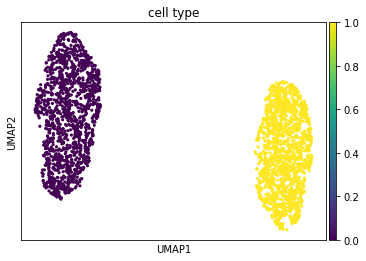

In [22]:
sc.pl.umap(adata, color = 'cell type')

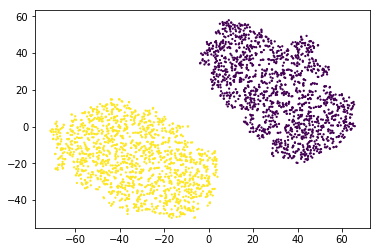

In [23]:
X_embedded = TSNE(n_components=2).fit_transform(gene_dataset.X)
#raw_plt = plt.scatter(X_embedded[:,0], X_embedded[:,1], c = gene_dataset.labels)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = gene_dataset.labels, s = [1.5]*len(X_embedded))
plt.savefig('./figures/raw.80132019.3000.png')

In [25]:
vae = VAE(gene_dataset.nb_genes, gene_dataset.n_labels,
                 n_hidden = n_hidden, n_latent = n_latent, n_layers = n_layers)

In [26]:
# Initialization
D_init = vae.get_sample_D(torch.from_numpy(gene_dataset.X))
L_init = vae.get_sample_L(torch.from_numpy(gene_dataset.X))
mu_init = vae.get_sample_mu(torch.from_numpy(gene_dataset.X))

In [29]:
trainer = Trainer(vae, gene_dataset,  kl =  0.1, batch_size=batch_size)
trainer.train(n_epochs=n_epochs, lr=lr)

training:   0%|          | 0/150 [00:00<?, ?it/s]part2 =  tensor(53.3370, grad_fn=<MeanBackward1>) KL =  tensor(181.1440, grad_fn=<MulBackward0>)
part2 =  tensor(53.9107, grad_fn=<MeanBackward1>) KL =  tensor(172.4393, grad_fn=<MulBackward0>)
training:   1%|          | 1/150 [00:00<00:22,  6.75it/s]part2 =  tensor(53.2516, grad_fn=<MeanBackward1>) KL =  tensor(167.8552, grad_fn=<MulBackward0>)
part2 =  tensor(53.7841, grad_fn=<MeanBackward1>) KL =  tensor(158.3621, grad_fn=<MulBackward0>)
part2 =  tensor(53.6395, grad_fn=<MeanBackward1>) KL =  tensor(153.1893, grad_fn=<MulBackward0>)
part2 =  tensor(53.2206, grad_fn=<MeanBackward1>) KL =  tensor(146.6317, grad_fn=<MulBackward0>)
training:   2%|▏         | 3/150 [00:00<00:17,  8.38it/s]part2 =  tensor(53.2572, grad_fn=<MeanBackward1>) KL =  tensor(143.0852, grad_fn=<MulBackward0>)
part2 =  tensor(53.2830, grad_fn=<MeanBackward1>) KL =  tensor(139.7062, grad_fn=<MulBackward0>)
part2 =  tensor(52.9127, grad_fn=<MeanBackward1>) KL =  tenso

In [30]:
# Estimation after training
D_out = trainer.model.get_sample_D(torch.from_numpy(gene_dataset.X))
L_out = trainer.model.get_sample_L(torch.from_numpy(gene_dataset.X))
mu_out = trainer.model.get_sample_mu(torch.from_numpy(gene_dataset.X))

In [31]:
part2 = log_gaussian_positive(torch.from_numpy(gene_dataset.X), mu_out, D_out, L_out, eps=1e-8)
print(torch.mean(part2))

tensor(-35.7413, grad_fn=<MeanBackward1>)


In [408]:
print(D_out, D_init)

tensor([[0.6900, 1.4626, 2.7499,  ..., 1.2594, 1.8727, 1.3656],
        [0.7062, 1.2699, 3.3886,  ..., 1.5452, 1.8801, 1.4190],
        [0.7119, 1.2954, 3.2171,  ..., 1.4195, 1.7998, 1.3900],
        ...,
        [0.3981, 1.7167, 3.4050,  ..., 0.6139, 1.5120, 1.2680],
        [0.7389, 1.3022, 3.3435,  ..., 1.5072, 1.7615, 1.3750],
        [0.6090, 1.2064, 3.8168,  ..., 1.7268, 2.1790, 1.5247]],
       grad_fn=<ExpBackward>) tensor([[0.7243, 1.1195, 1.6554,  ..., 0.9944, 1.2907, 1.5311],
        [0.8784, 1.1942, 1.4077,  ..., 1.2507, 1.4085, 1.1006],
        [0.6702, 1.2514, 1.5772,  ..., 0.9597, 1.5669, 1.5441],
        ...,
        [0.9280, 1.2794, 1.6667,  ..., 1.2209, 1.6070, 1.0091],
        [0.7590, 1.1088, 1.5035,  ..., 1.1415, 1.3926, 1.0371],
        [0.7087, 1.1635, 1.6292,  ..., 0.9932, 1.3321, 1.4343]],
       grad_fn=<ExpBackward>)


In [409]:
torch.mean(D_out)

tensor(1.3948, grad_fn=<MeanBackward1>)

In [410]:
print(mu_init, mu_out, sim1.meanmat)

tensor([[ 0.3696, -0.2032, -0.5561,  ...,  0.1971, -0.3907, -0.2954],
        [ 0.2295, -0.1444, -0.3819,  ..., -0.1532, -0.1582, -0.2210],
        [ 0.4283, -0.2466, -0.5922,  ...,  0.2200, -0.4254, -0.1941],
        ...,
        [ 0.1874, -0.0916, -0.3739,  ...,  0.0972, -0.4822, -0.1652],
        [ 0.2520, -0.1117, -0.4912,  ...,  0.1083, -0.5935, -0.0825],
        [ 0.2207,  0.0403, -0.0734,  ..., -0.2616, -0.4671,  0.0033]],
       grad_fn=<AddmmBackward>) tensor([[-0.1003, -3.5111,  0.0313,  ...,  1.9974, -1.0693, -3.1913],
        [-0.1579, -3.4244, -0.0246,  ...,  2.0047, -1.0484, -3.2016],
        [-0.0456, -3.5516,  0.0465,  ...,  2.1211, -1.1534, -3.2319],
        ...,
        [-0.1536, -3.4047,  0.0295,  ...,  2.0253, -1.0156, -3.2468],
        [-0.1316, -3.5866,  0.0548,  ...,  2.0638, -1.0582, -3.3191],
        [-0.0973, -3.5370,  0.0356,  ...,  2.0406, -1.1143, -3.1945]],
       grad_fn=<AddmmBackward>) [array([-4.19460896, -4.54912913, -0.72709397,  1.43760508,  2.07941

([array([   0.,    0.,    0.,    0., 1500.,    0.,    0.,    0.,    0.,
            0.]),
  array([   0.,    0.,    0.,    0., 1500.,    0.,    0.,    0.,    0.,
            0.]),
  array([  0.,   1.,   0.,   9.,  97., 352., 531., 363., 126.,  21.]),
  array([ 16.,  79., 207., 431., 393., 272.,  82.,  17.,   3.,   0.])],
 array([-4.74382   , -3.328836  , -1.913852  , -0.4988678 ,  0.91611636,
         2.3311005 ,  3.7460847 ,  5.161069  ,  6.5760527 ,  7.991037  ,
         9.406021  ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

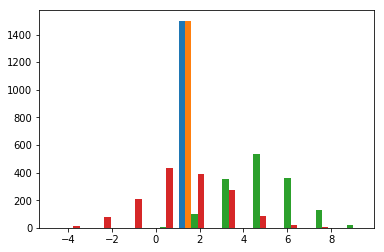

In [32]:
# Comparing true mean and estimated means
i= 0
plt.hist([mu_out[0:1500,i].detach().numpy(),mu_out[1500:3000,i].detach().numpy(), gene_dataset.X[0:1500,i], gene_dataset.X[1500:3000,i]], label = ["ct_1_out","ct_2_out", "ct_1", "ct_2"])

([array([  0.,   0., 592., 908.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0., 566., 934.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   1.,   0.,   9.,  97., 352., 531., 363., 126.,  21.]),
  array([ 16.,  79., 207., 431., 393., 272.,  82.,  17.,   3.,   0.])],
 array([-4.74382   , -3.328836  , -1.913852  , -0.4988678 ,  0.91611636,
         2.3311005 ,  3.7460847 ,  5.161069  ,  6.5760527 ,  7.991037  ,
         9.406021  ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

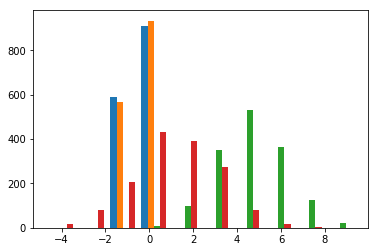

In [33]:
# Comparing true mean and initial means. Turns out that the estimation are not improved from initials after training although the loss function is lowered down.
plt.hist([mu_init[0:1500,i].detach().numpy(),mu_init[1500:3000,i].detach().numpy(), gene_dataset.X[0:1500,i], gene_dataset.X[1500:3000,i]], label = ["ct_1_init","ct_2_init", "ct_1", "ct_2"])

([array([135., 198., 331., 345., 176., 117.,  88.,  56.,  30.,  24.]),
  array([133., 186., 337., 341., 187., 117.,  91.,  48.,  30.,  30.]),
  array([  4.,  24.,  75., 300., 895., 197.,   5.,   0.,   0.,   0.]),
  array([  5.,  34.,  72., 237., 903., 242.,   7.,   0.,   0.,   0.])],
 array([0.27348968, 0.4471532 , 0.6208167 , 0.79448026, 0.96814376,
        1.1418073 , 1.3154708 , 1.4891343 , 1.6627979 , 1.8364614 ,
        2.010125  ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

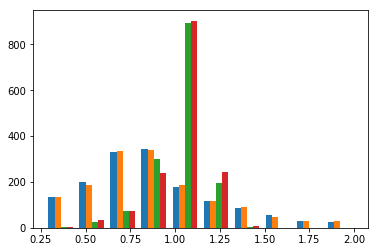

In [34]:
plt.hist([D_out[0:1500,i].detach().numpy(),D_out[1500:3000,i].detach().numpy(), \
          D_init[0:1500,i].detach().numpy(),D_init[1500:3000,i].detach().numpy()], \
         label = ["ct_1_out","ct_2_out", "ct_1_init", "ct_2_init"])

In [35]:
z = trainer.get_latent(give_mean =True)
z = z[0].numpy()

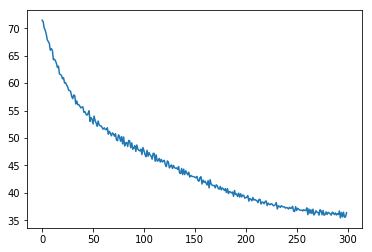

In [36]:
# Loss function curve with iterations
len(trainer.history)
trainer.plot_history()

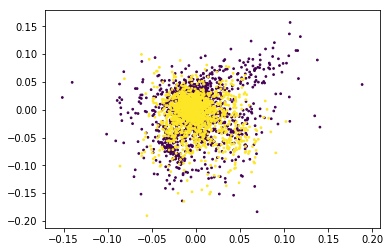

In [37]:
plt.scatter(z[:,0], z[:,1], c = gene_dataset.labels, s = [3]*len(z))
plt.savefig('./figures/vae.8052019.3000.png')

In [38]:
z_init = trainer.init_z[0]
z_out = trainer.get_latent(give_mean =True)[0]

In [39]:
print(z_init, z_init-z_out)
z_diff = (z_out - z_init).numpy()

tensor([[ 0.0619, -0.2230],
        [ 0.1118, -0.3310],
        [ 0.1061, -0.2095],
        ...,
        [ 0.1528, -0.1841],
        [ 0.0700, -0.3427],
        [ 0.1263, -0.2974]]) tensor([[ 0.0267, -0.1857],
        [ 0.1023, -0.3254],
        [ 0.1234, -0.1547],
        ...,
        [ 0.1501, -0.1087],
        [ 0.0605, -0.3069],
        [ 0.1514, -0.2685]])


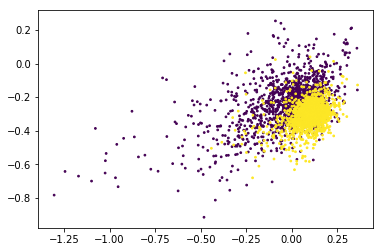

In [40]:
plt.scatter(z_init[:,0], z_init[:,1], c = gene_dataset.labels, s = [3]*len(z))

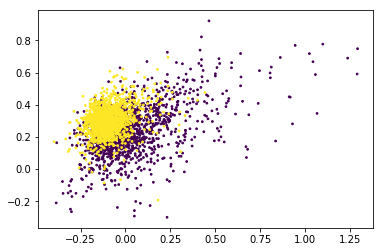

In [41]:
plt.scatter(z_diff[:,0], z_diff[:,1], c = gene_dataset.labels, s = [3]*len(z))